In [1]:
"""
Fit GLMs.

"""

# imports - general
import numpy as np 
import pandas as pd
from sklearn import linear_model
from sklearn import preprocessing
# imports - custom
import sys
sys.path.append("code")

# plotting
import matplotlib.pyplot as plt



In [7]:
# convert flat_spectra from list to np array
df = pd.read_pickle('all_features_500ms.pkl')

# df = pd.read_csv('all_features.csv')
# for i,sf in enumerate(df['spectra_flat']):
#     if type(sf) is str:
#         split_spec = sf.replace('n', '').strip('[]').split()
#         num_list = [float(s) for s in split_spec]

#         df['spectra_flat'][i] = np.array(num_list)

# for i,f in enumerate(df['freqs']):
#     if type(f) is str:
#         split_spec = sf.replace('n', '').strip('[]').split()
#         num_list = [float(s) for s in split_spec]

#         df['freqs'][i] = np.array(num_list)


In [8]:
subj_id = np.unique(df['subject_id'])


In [9]:
# select session and region
extract_var = ['trial', 'structure', 'spike_count', 'burst_count', 'num_licks', 'num_rewards', 'num_blinks', 'mean_speed', 'exponent', 'spectra_flat', 'freqs']

zT = np.zeros((len(subj_id),8))
for s, subj in enumerate(subj_id):
    session_df = df.loc[df['subject_id'] == subj, extract_var]

    send_region = session_df.loc[session_df['structure']=='LGd']

    receive_region = session_df.loc[session_df['structure']=='VISp']

    # select variables of interest

    X_df = send_region.loc[:,['trial', 'spike_count', 'burst_count',  'num_licks', 'num_rewards', 'num_blinks', 'mean_speed']]
    X_df = X_df.groupby('trial', as_index=False).mean()

    Y_df = receive_region.loc[:, ['trial','exponent']]
    Y_df = Y_df.groupby('trial', as_index=False).mean()

    # convert to no to use as regressors
    x = X_df.to_numpy()
    x -= x.mean()
    # add constant
    x = np.concatenate((np.ones((len(x),1)), x),axis=1)

    y = Y_df['exponent'].to_numpy() 


    # scaling changes constant to 0 which is causing problems
    scaler = preprocessing.StandardScaler().fit(x)
    x_scaled = scaler.transform(x)

    # using glmtools implementation here to reduce multicollinearity problems

    x_inv = np.linalg.pinv(x)

    # fit GLM - get coefs
    coefs = x_inv.dot(y)

    pred = x.dot(coefs)
    # sum of squares - check if right axis??
    rss = np.sum(np.power(y-pred,2))

    dof = y.shape[0] - np.linalg.matrix_rank(x_inv)

    # varcope
    var_forming_matrix = np.diag(np.linalg.pinv(x.T@x))
    varcope = var_forming_matrix * (rss/dof)

    # T values
    T_coefs = coefs/varcope

    num_perm = 10000

    # create null distribution
    T_coefs_perm = np.empty((num_perm, T_coefs.shape[0]))

    for n in range(num_perm):

        indices = np.random.permutation(y.shape[0])
        shuf_y = y[indices]

        # fit GLM - get coefs
        coefs = x_inv.dot(shuf_y)

        pred = x.dot(coefs)
        # sum of squares - check if right axis??
        rss = np.sum(np.power(shuf_y-pred,2))

        dof = y.shape[0] - np.linalg.matrix_rank(x_inv)

        # varcope
        var_forming_matrix = np.diag(np.linalg.pinv(x.T@x))
        varcope = var_forming_matrix * (rss/dof)

        # T values
        T_coefs_perm[n] = coefs/varcope


    # z-score based on null distribution
    zT[s] = (T_coefs-np.mean(T_coefs_perm))/(np.std(T_coefs_perm))


Text(0, 0.5, 'z score regressor')

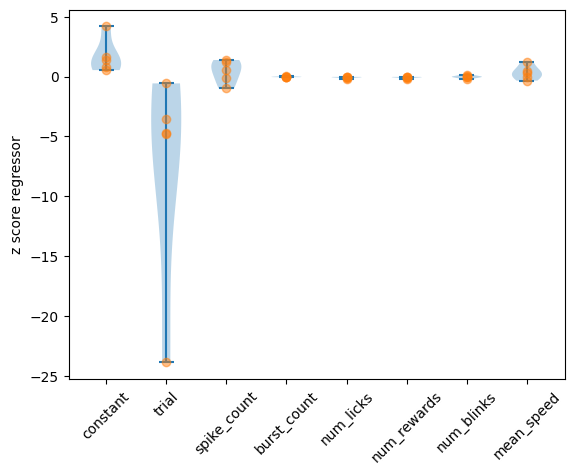

In [10]:
reg_names = ['constant', 'trial', 'spike_count', 'burst_count',  'num_licks', 'num_rewards', 'num_blinks', 'mean_speed']
fig, ax = plt.subplots()
ax.violinplot(zT)
scatters = zT
ax.scatter(np.tile(np.arange(len(reg_names))+1,(5,1)), scatters, alpha=0.5, color='tab:orange', zorder=2)
ax.set_xticks(np.arange(len(reg_names))+1, labels = reg_names, rotation=45)
ax.set_ylabel('z score regressor')


In [11]:
zT[:, 2]

array([ 0.53537245,  1.37914553,  1.17617805, -0.9798355 , -0.08278389])

In [12]:
freqs = df.loc[:, ['freqs']]
FREQS = freqs.freqs[0]

In [13]:
send_region = session_df.loc[session_df['structure']=='LGd']
X_df

,trial,spike_count,burst_count,num_licks,num_rewards,num_blinks,mean_speed
0,0,117.0,0.0,0.0,0.0,0.0,31.548061
1,1,81.0,0.0,0.0,0.0,0.0,38.434610
2,2,70.0,0.0,0.0,0.0,0.0,34.456331
3,3,77.0,0.0,0.0,0.0,0.0,42.984401
4,4,76.0,0.0,0.0,0.0,0.0,41.201123
...,...,...,...,...,...,...,...
145,145,62.0,0.0,0.0,0.0,0.0,36.337118
146,146,69.0,0.0,0.0,0.0,0.0,36.771088
147,147,93.0,0.0,0.0,0.0,0.0,37.443585
148,148,70.0,0.0,0.0,0.0,0.0,35.578677


In [14]:
zT_freq = np.zeros((len(subj_id),len(FREQS),8))
T_coefs = np.zeros((len(subj_id),len(FREQS),8))
for s, subj in enumerate(subj_id):
    session_df = df.loc[df['subject_id'] == subj, extract_var]

    send_region = session_df.loc[session_df['structure']=='LGd']

    receive_region = session_df.loc[session_df['structure']=='VISp']

    # design matrix
    X_df = send_region.loc[:,['trial', 'spike_count', 'burst_count',  'num_licks', 'num_rewards', 'num_blinks', 'mean_speed']]
    X_df = X_df.groupby('trial', as_index=False).mean()
    # convert to no to use as regressors
    x = X_df.to_numpy()
    x -= x.mean()
    # add constant
    x = np.concatenate((np.ones((len(x),1)), x),axis=1)
    # scaling changes constant to 0 which is causing problems
    scaler = preprocessing.StandardScaler().fit(x)
    x_scaled = scaler.transform(x)

    # using glmtools implementation here to reduce multicollinearity problems

    x_inv = np.linalg.pinv(x)

    Y_df = receive_region.loc[:, ['trial','spectra_flat']]
    Y_df = Y_df.groupby('trial', as_index=False).mean()
    # concatenate spectra into 1 matrix
    spectra_trl = np.zeros((len(Y_df), len(FREQS)))
    for sp, spectrum in enumerate(Y_df.spectra_flat):
        spectra_trl[sp, :] = spectrum

    # fit GLM to each frequency
    for f in range(len(FREQS)):

        # get power at current frequency for all trials
        y = spectra_trl[:,f]
    
        # fit GLM - get coefs
        coefs = x_inv.dot(y)

        pred = x.dot(coefs)
        # sum of squares - check if right axis??
        rss = np.sum(np.power(y-pred,2))

        dof = y.shape[0] - np.linalg.matrix_rank(x_inv)

        # varcope
        var_forming_matrix = np.diag(np.linalg.pinv(x.T@x))
        varcope = var_forming_matrix * (rss/dof)

        # T values
        T_coefs[s,f,:] = coefs/varcope

        # null distribution
        num_perm = 100

        T_coefs_perm = np.empty((num_perm, T_coefs.shape[-1]))

        for n in range(num_perm):

            indices = np.random.permutation(y.shape[0])
            shuf_y = y[indices]

            # fit GLM - get coefs
            coefs = x_inv.dot(shuf_y)

            pred = x.dot(coefs)
            # sum of squares - check if right axis??
            rss = np.sum(np.power(shuf_y-pred,2))

            dof = y.shape[0] - np.linalg.matrix_rank(x_inv)

            # varcope
            var_forming_matrix = np.diag(np.linalg.pinv(x.T@x))
            varcope = var_forming_matrix * (rss/dof)

            # T values
            T_coefs_perm[n] = coefs/varcope

        # z-score based on null distribution
        zT_freq[s,f,:] = (T_coefs[s,f,:]-np.mean(T_coefs_perm))/(np.std(T_coefs_perm))

Text(0.5, 0.98, 'z-scored regressors')

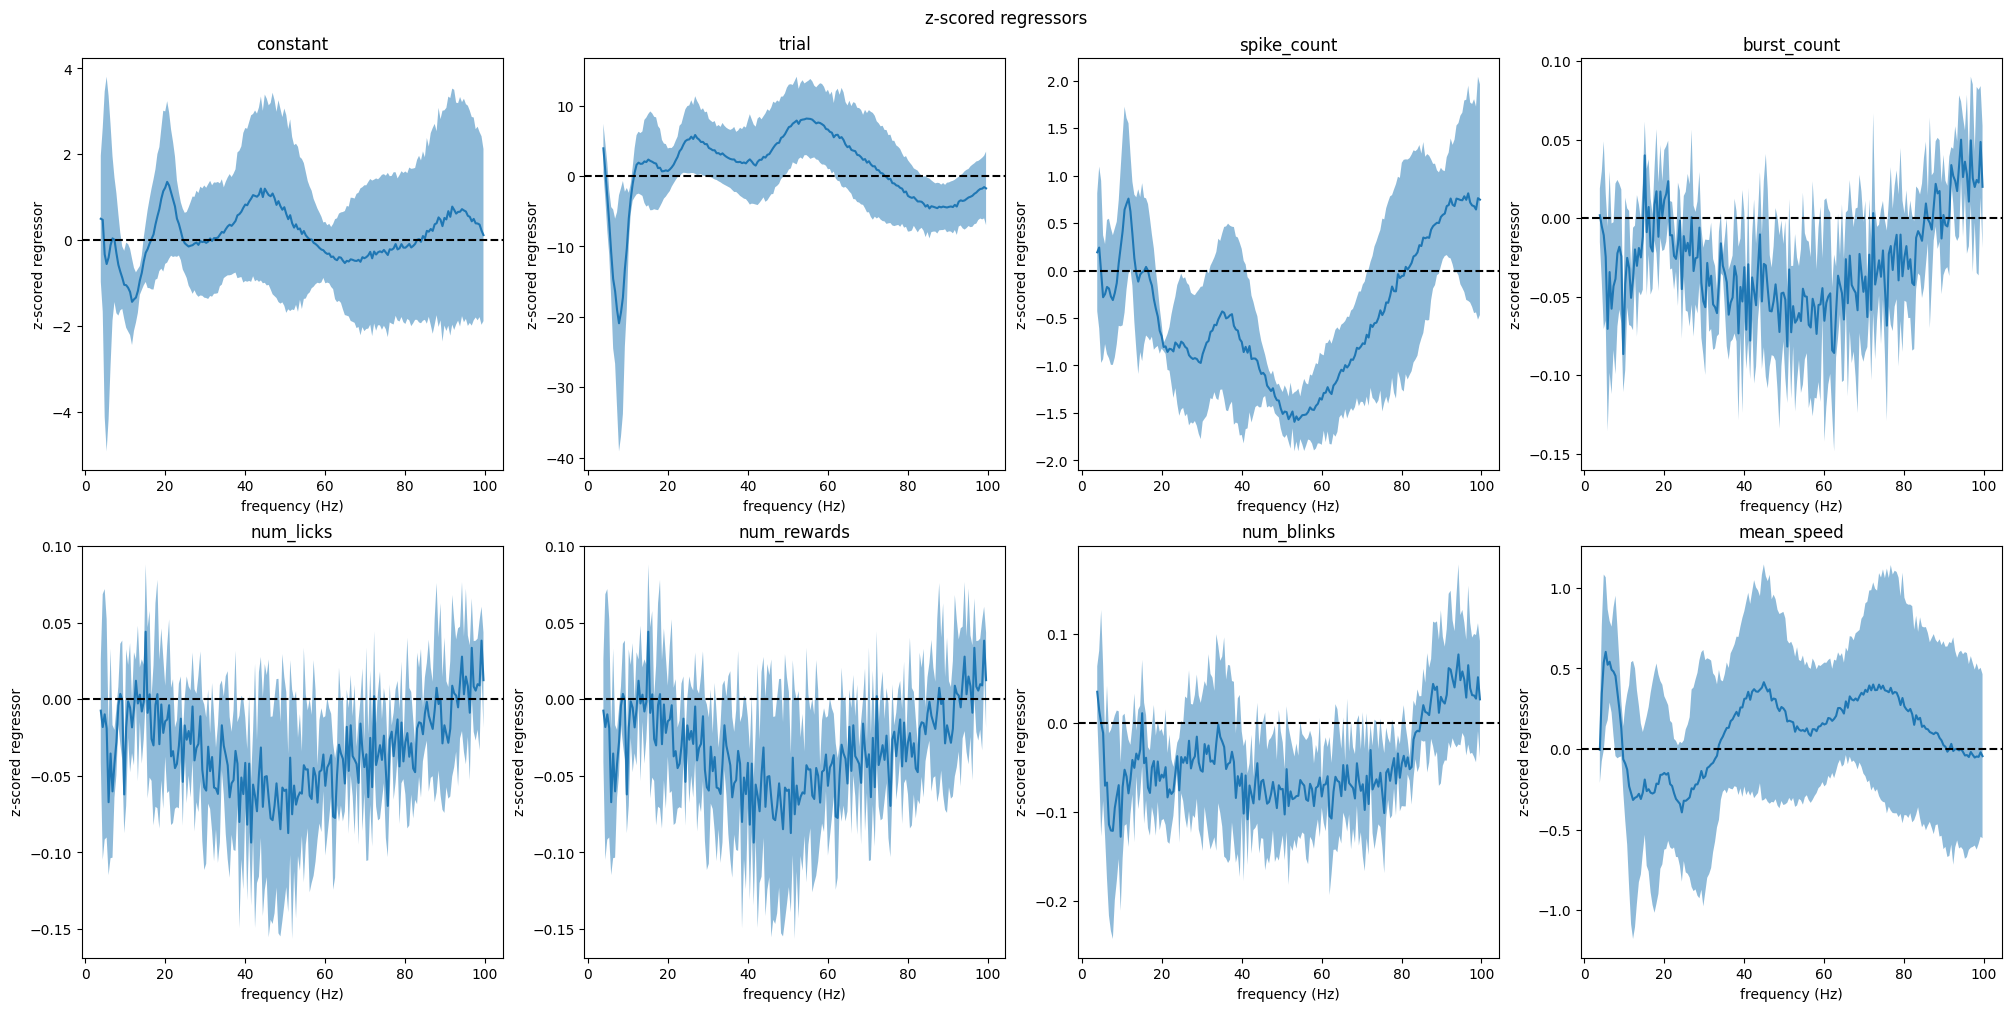

In [15]:
reg_names = ['constant', 'trial', 'spike_count', 'burst_count',  'num_licks', 'num_rewards', 'num_blinks', 'mean_speed']

fig, ax = plt.subplots(2,4,figsize=(20,10), constrained_layout=True)

ax = ax.ravel()

for r in range(len(reg_names)):
    ax[r].plot(FREQS, zT_freq[:,:,r].mean(axis=0))
    ax[r].fill_between(FREQS, zT_freq[:,:,r].mean(axis=0)-zT_freq[:,:,r].std(axis=0), zT_freq[:,:,r].mean(axis=0)+zT_freq[:,:,r].std(axis=0), alpha=0.5)
    ax[r].set_title(reg_names[r])
    ax[r].set_xlabel('frequency (Hz)')
    ax[r].set_ylabel('z-scored regressor')
    ax[r].axhline(y=0.0, linestyle='--', color='k')

fig.suptitle('z-scored regressors')


AttributeError: 'Figure' object has no attribute 'set_title'

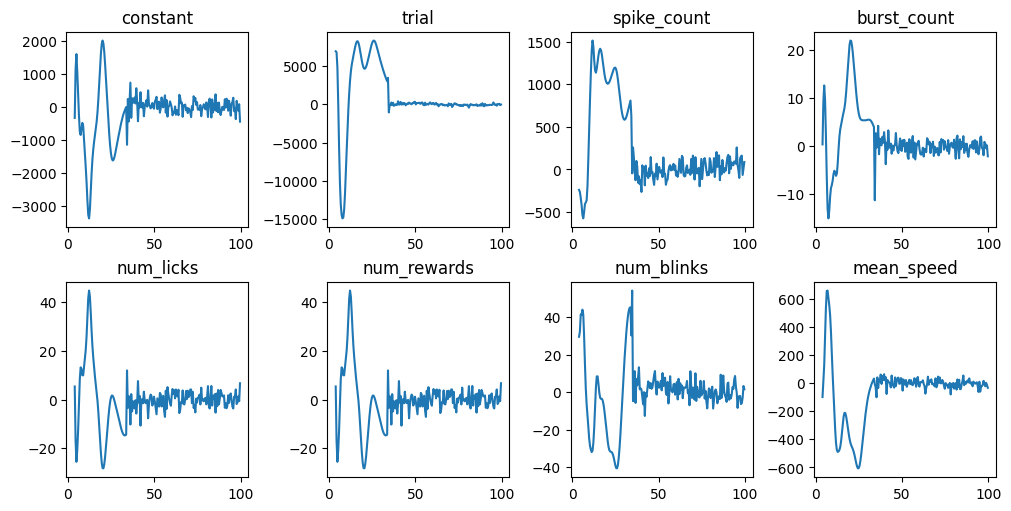

In [ ]:
reg_names = ['constant', 'trial', 'spike_count', 'burst_count',  'num_licks', 'num_rewards', 'num_blinks', 'mean_speed']

fig, ax = plt.subplots(2,4,figsize=(10,5), constrained_layout=True)

ax = ax.ravel()

for r in range(len(reg_names)):
    ax[r].plot(FREQS, T_coefs[:,:,r].mean(axis=0))
    ax[r].set_title(reg_names[r])

fig.set_title('T-values of regressors')

In [ ]:

# OLD CODE
def main():
    # load results and reformat 
    
    df = pd.read_csv('scratch/feature_df.csv')
    # do we need this?
    num_models = len(Y_FEATURE)*len(STRUCTURES)*len(SESSIONS)

    df_results = pd.DataFrame({
    'session_id'     : [None]*num_models,
    'brain_structure x': [None]*num_models,
    'brain_structure y': [None]*num_models,
    'y_feature' : [None]*num_models,
    'r_squ' : [None]*num_models})
    for ii, feature in enumerate(X_FEATURE):
        df_results[f"coef_{feature}"] = [None]*num_models

    # loop over sessions - fit model for each session
    c = 0
    for session in SESSIONS:
        print(f"fitting session: " + str(session))
        for s in STRUCTURES:
            xs, ys = s
            for yf in Y_FEATURE:
                # data frame session
                df_s = df[df['session_id'] == session]

                # get data for current session, predictor structure, observation structure
                y = df_s[df_s['brain_structure'] == ys][yf].values
                x = df_s[df_s['brain_structure'] == xs][X_FEATURE].values

                

                x = np.concatenate((np.ones((len(x),1)),x),axis=1)

                # fit model

                # scaling doesn't seem to be necessary
                scaler = preprocessing.StandardScaler().fit(x)
                x_scaled = scaler.transform(x)

                # fit GLM
                reg = linear_model.LinearRegression().fit(x_scaled, y)

                # r2
                r2 = reg.score(x_scaled, y)

                # coefficients
                coefs = reg.coef_

                # sum of squares - check if right axis??
                rss = np.sum(np.power(y - reg.predict(X=x), 2))

                dof = y.shape[0] - np.linalg.matrix_rank(x_scaled)

                # varcope
                var_forming_matrix = np.linalg.pinv(x_scaled.T*x_scaled)
                varcope = var_forming_matrix * (rss/dof)

                # T values
                T_coefs = coefs/varcope 

                # store model results
                df_results['session_id'][c] = session
                df_results['brain_structure x'][c] = xs
                df_results['brain_structure y'][c] = ys
                
                df_results['y_feature'][c] = yf
                df_results['r_squ'][c] = r2
                for ii, feature in enumerate(X_FEATURE):
                    df_results[f"coef_{feature}"][c] = coefs[ii+1]

                # increase count
                c += 1

    # save results
    df_results.to_csv('scratch/glm_results.csv', index=False)


if __name__ == '__main__':
    main()